In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pd.set_option('display.max_rows', None)
plt.style.use('seaborn')

In [3]:
# Initiate dataset

calendar = pd.read_csv('data/calendar.csv')
listing  = pd.read_csv('data/listings.csv')
review   = pd.read_csv('data/reviews.csv')

In [20]:
# Filter dataset
listing_filtered  = listing[['id', 'host_response_time', 'host_response_rate',
                             'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
                             'is_location_exact', 'property_type', 'room_type', 'accommodates',
                             'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities',
                             'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 
                             'minimum_nights', 'maximum_nights', 'calendar_updated',
                             'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                             'review_scores_checkin', 'review_scores_communication',
                             'review_scores_location', 'review_scores_value',
                             'require_guest_profile_picture', 'require_guest_phone_verification', 
                             'calculated_host_listings_count', 'reviews_per_month']]
df_raw = pd.merge(listing_filtered, calendar, left_on='id', right_on='listing_id')

In [22]:
# Check Metadata
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 38 columns):
id                                  1393570 non-null int64
host_response_time                  1202675 non-null object
host_response_rate                  1202675 non-null object
host_is_superhost                   1392840 non-null object
host_listings_count                 1392840 non-null float64
host_total_listings_count           1392840 non-null float64
is_location_exact                   1393570 non-null object
property_type                       1393205 non-null object
room_type                           1393570 non-null object
accommodates                        1393570 non-null int64
bathrooms                           1387730 non-null float64
bedrooms                            1391380 non-null float64
beds                                1393205 non-null float64
bed_type                            1393570 non-null object
amenities                           1393570 

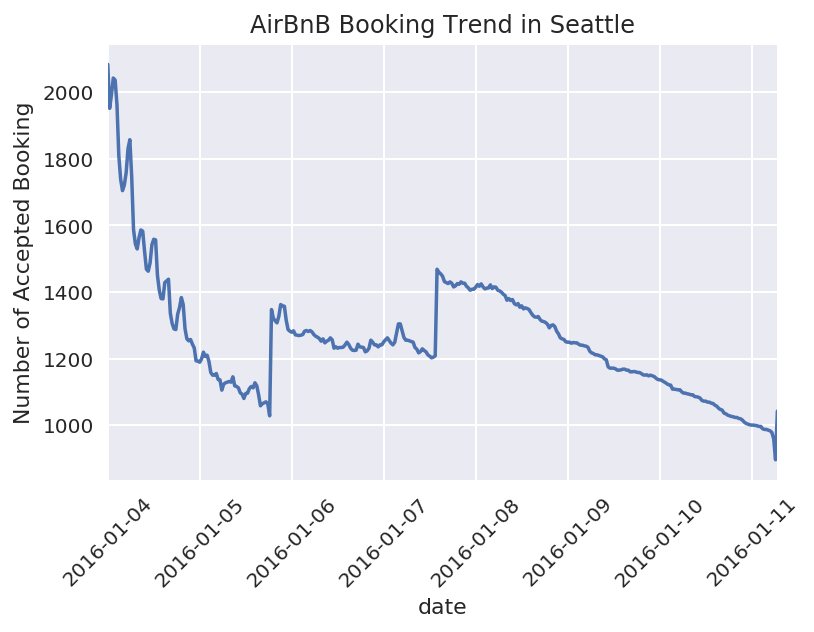

In [38]:
def generate_booking_trend(calendar):
    """
    This function generates a booking trend graph for an AirBnB property in Seattle.

    Input:
    - calendar: pandas dataframe with a column named "available" indicating the availability of the property on each date.

    Output:
    - A line graph of the booking trend over time.
    """

    # Create a new column in the calendar dataframe to indicate if the property is booked or not on each date.
    calendar['booked'] = np.where(calendar['available'] == 't', 0, 1)

    # Group the calendar dataframe by date and sum the "booked" column to get the total number of bookings for each date.
    trend = calendar.groupby(['date']).sum().reset_index()

    # Plot a line graph of the booking trend over time.
    ax = trend.plot(x='date', y='booked', kind='line')
    ax.set_xticklabels(trend['date'], rotation=45)  # Set the x-axis labels to the date values.
    plt.title("AirBnB Booking Trend in Seattle")
    plt.ylabel("Number of Accepted Booking")
    plt.legend().remove()  # Remove the legend from the graph.
    
    return ax

booking_trend = generate_booking_trend(calendar)

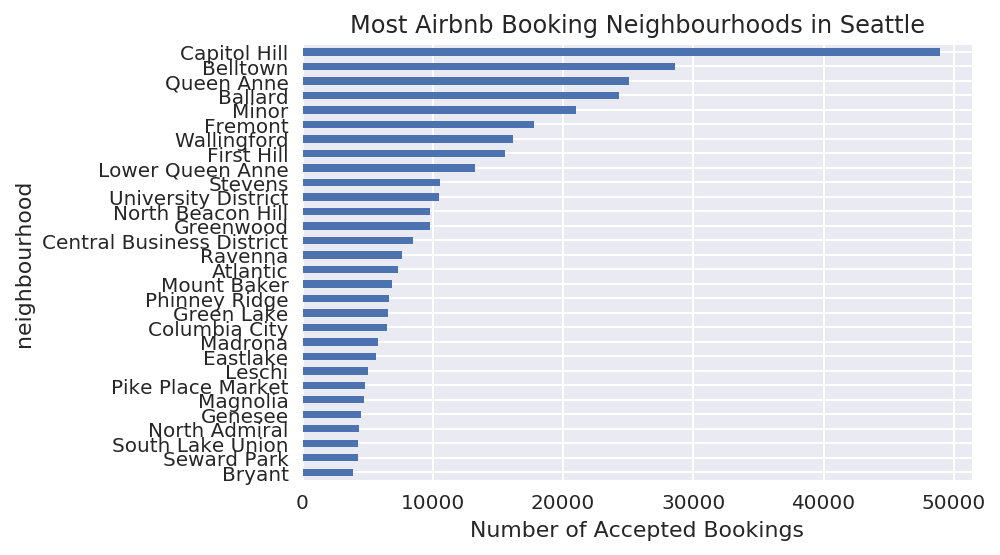

In [39]:
def plot_top_neighborhoods(listing, calendar):
    """
    Returns a horizontal bar chart of the top 30 Airbnb booking neighborhoods in Seattle.
    
    Args:
    - listing (pandas.DataFrame): A DataFrame of Airbnb listings that includes the columns 'id' and 'neighbourhood'.
    - calendar (pandas.DataFrame): A DataFrame of Airbnb booking data that includes the columns 'listing_id' and 'booked'.
    
    Returns:
    - None. Displays a horizontal bar chart of the top 30 Airbnb booking neighborhoods in Seattle.
    """
    # Merge the listing and calendar data to get the number of bookings for each neighborhood
    listing_profile = pd.merge(listing[['id','neighbourhood']], 
                               calendar[['listing_id','booked']], 
                               left_on='id', right_on='listing_id', how='inner')

    # Group by neighborhood and sum the number of bookings
    booked = listing_profile.groupby(['neighbourhood']).sum()[['booked']]
    
    # Sort by number of bookings and select the top 30
    booked = booked.sort_values(['booked'], ascending=True).tail(30)

    # Create a horizontal bar chart
    booked.plot.barh()
    plt.title("Most Airbnb Booking Neighbourhoods in Seattle")
    plt.xlabel("Number of Accepted Bookings")
    plt.legend().remove()

plot_top_neighborhoods(listing, calendar)

In [40]:
def clean_data(df):
    """
    Cleans a pandas DataFrame and returns the cleaned DataFrame as well as a target variable DataFrame.
    
    Args:
    - df (pandas.DataFrame): A DataFrame to be cleaned.
    
    Returns:
    - X (pandas.DataFrame): A cleaned DataFrame containing the feature variables.
    - y (pandas.DataFrame): A DataFrame containing the target variable.
    """
    df = df.dropna(subset=['available'], axis=0)
    
    df.loc[:,'booked'] = np.where(df['available'] == 't', 0, 1)
    y = df['booked']
    
    for col in ['calendar_updated','cleaning_fee','amenities']:
        df.loc[:,col] = np.where(df[col].isnull(), 0, 1)
    
    for col in ['price','host_response_rate',]:
        df.loc[:,col] = np.where(df[col].isnull(), '0', df[col])
        df.loc[:,col] = df[col].apply(lambda x: x.replace('%','').replace('$','').replace(',','')).astype(float)
      
    df  = df.drop(['available','date','listing_id', 'id','booked'], axis=1)
    
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    
    return X, y
    
X, y = clean_data(df_raw)

In [42]:
def train_test_logistic_regression(X, y, test_size=0.2, random_state=17):
    """
    Train a logistic regression model on the given dataset and return the trained model, predicted target variable on the 
    test data and the accuracy of the model on the test data.
    
    Inputs:
    - X: A pandas DataFrame of features used to train and test the model.
    - y: A pandas Series of binary target variable used to train and test the model.
    - test_size: A float representing the proportion of the dataset to include in the test split.
    - random_state: An integer representing the random state used for shuffling the data.

    Outputs:
    - lr: A trained LogisticRegression model.
    - y_pred: A numpy array of predicted target variable on the test data using the trained model.
    - accuracy: A float representing the accuracy of the model on the test data.
    """
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Create a logistic regression model
    lr = LogisticRegression(max_iter=3)

    # Train the model on the training data
    lr.fit(X_train, y_train)

    # Use the trained model to make predictions on the test data
    y_pred = lr.predict(X_test)

    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    return lr, y_pred, accuracy

lr_model = train_test_logistic_regression(X, y, test_size=0.2, random_state=17)
print(lr_model[2])

0.991345967551


In [44]:
def coef_weights(coefficients, X_train):
    
    # create a dataframe to store the coefficients and their corresponding features
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = pd.DataFrame(coefficients).T
    
    # calculate the absolute value of the coefficients
    coefs_df['abs_coefs'] = np.abs(coefs_df['coefs'])
    
    # sort the dataframe in ascending order of absolute coefficients
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=True).set_index('est_int')
    
    return coefs_df

# use the function to get the coefficients of the logistic regression model
coef_df = coef_weights(lr.coef_, X_train)

# display the top 10 results
coef_df.head(10)

,coefs,abs_coefs
est_int,,
security_deposit_$650.00,2.876703e-09,2.876703e-09
property_type_Dorm,-1.059983e-08,1.059983e-08
property_type_Bungalow,1.333091e-08,1.333091e-08
security_deposit_$499.00,-1.838518e-08,1.838518e-08
extra_people_$71.00,-1.913136e-08,1.913136e-08
security_deposit_$780.00,-2.137980e-08,2.137980e-08
security_deposit_$360.00,-2.388216e-08,2.388216e-08
security_deposit_$399.00,-2.411413e-08,2.411413e-08
extra_people_$68.00,3.003623e-08,3.003623e-08


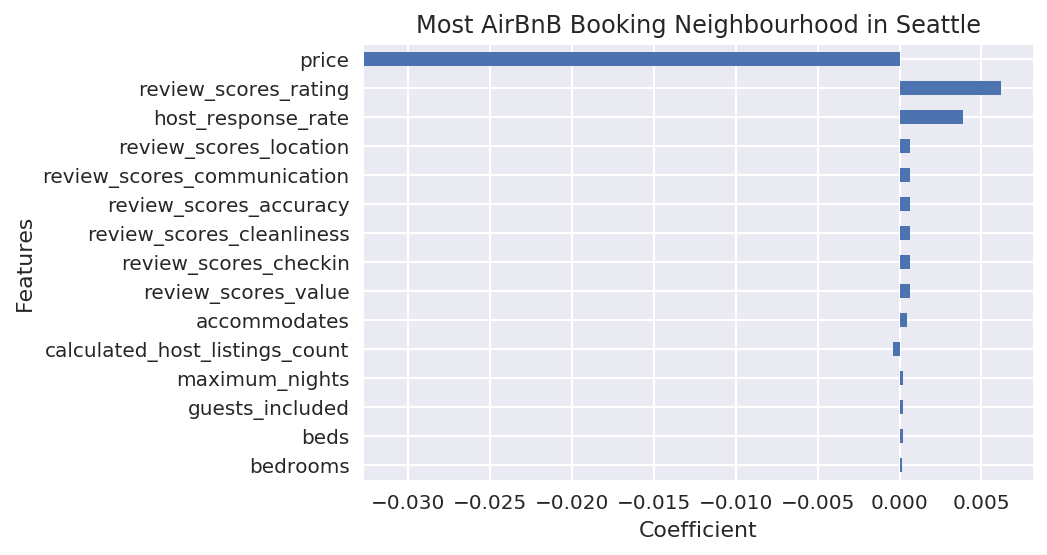

In [45]:
def plot_top_coef_features(coef_df):
    '''
    Plot the 15 features with the highest coefficients.
    
    Parameters:
    - coef_df: a pandas DataFrame containing the features and their corresponding coefficients sorted in 
               ascending order of absolute coefficients.
    
    Returns:
    - A horizontal bar plot of the 15 features with the highest coefficients. The plot shows the coefficient 
      values of each feature. The plot has a title, x-label, y-label, and legend removed.
    '''
    coef_df['coefs'].tail(15).plot.barh()
    plt.title("Most AirBnB Booking Neighbourhood in Seattle")
    plt.xlabel("Coefficient")
    plt.ylabel("Features")
    plt.legend().remove()

# Use the function to plot the top features with the highest coefficients
plot_top_coef_features(coef_df)